In [1]:
from datasets import PICNN_FNLVQR_Banana
import torch

In [2]:
synthetic_dataset = PICNN_FNLVQR_Banana()
X_train, y_train = synthetic_dataset.sample_joint(n_points=10**6)
tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=1024)

In [3]:
from pushforward_operators import FlowMatchingQuantile
from classes import TrainParameters

In [4]:
quantile = FlowMatchingQuantile(
    feature_dimension=1,
    response_dimension=2,
    hidden_dimension=8,
    number_of_hidden_layers=2,
)

train_parameters = TrainParameters(
    number_of_epochs_to_train=20,
    optimizer_parameters=dict(
        lr=1e-1,
    ),
    scheduler_parameters=dict(
        eta_min=0
    ),
    verbose=True
)

In [5]:
_ = quantile.fit(
    dataloader=dataloader,
    train_parameters=train_parameters,
)

Epoch: 20, Flow Loss: 2.1969, LR: 0.000000: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


In [6]:
# path_for_models_weights = "../attic/models/flow_matching/flow_matching_picnn_banana.pth"
# quantile.save(path=path_for_models_weights)
# quantile = FlowMatchingQuantile.load_class(path=path_for_models_weights).eval()

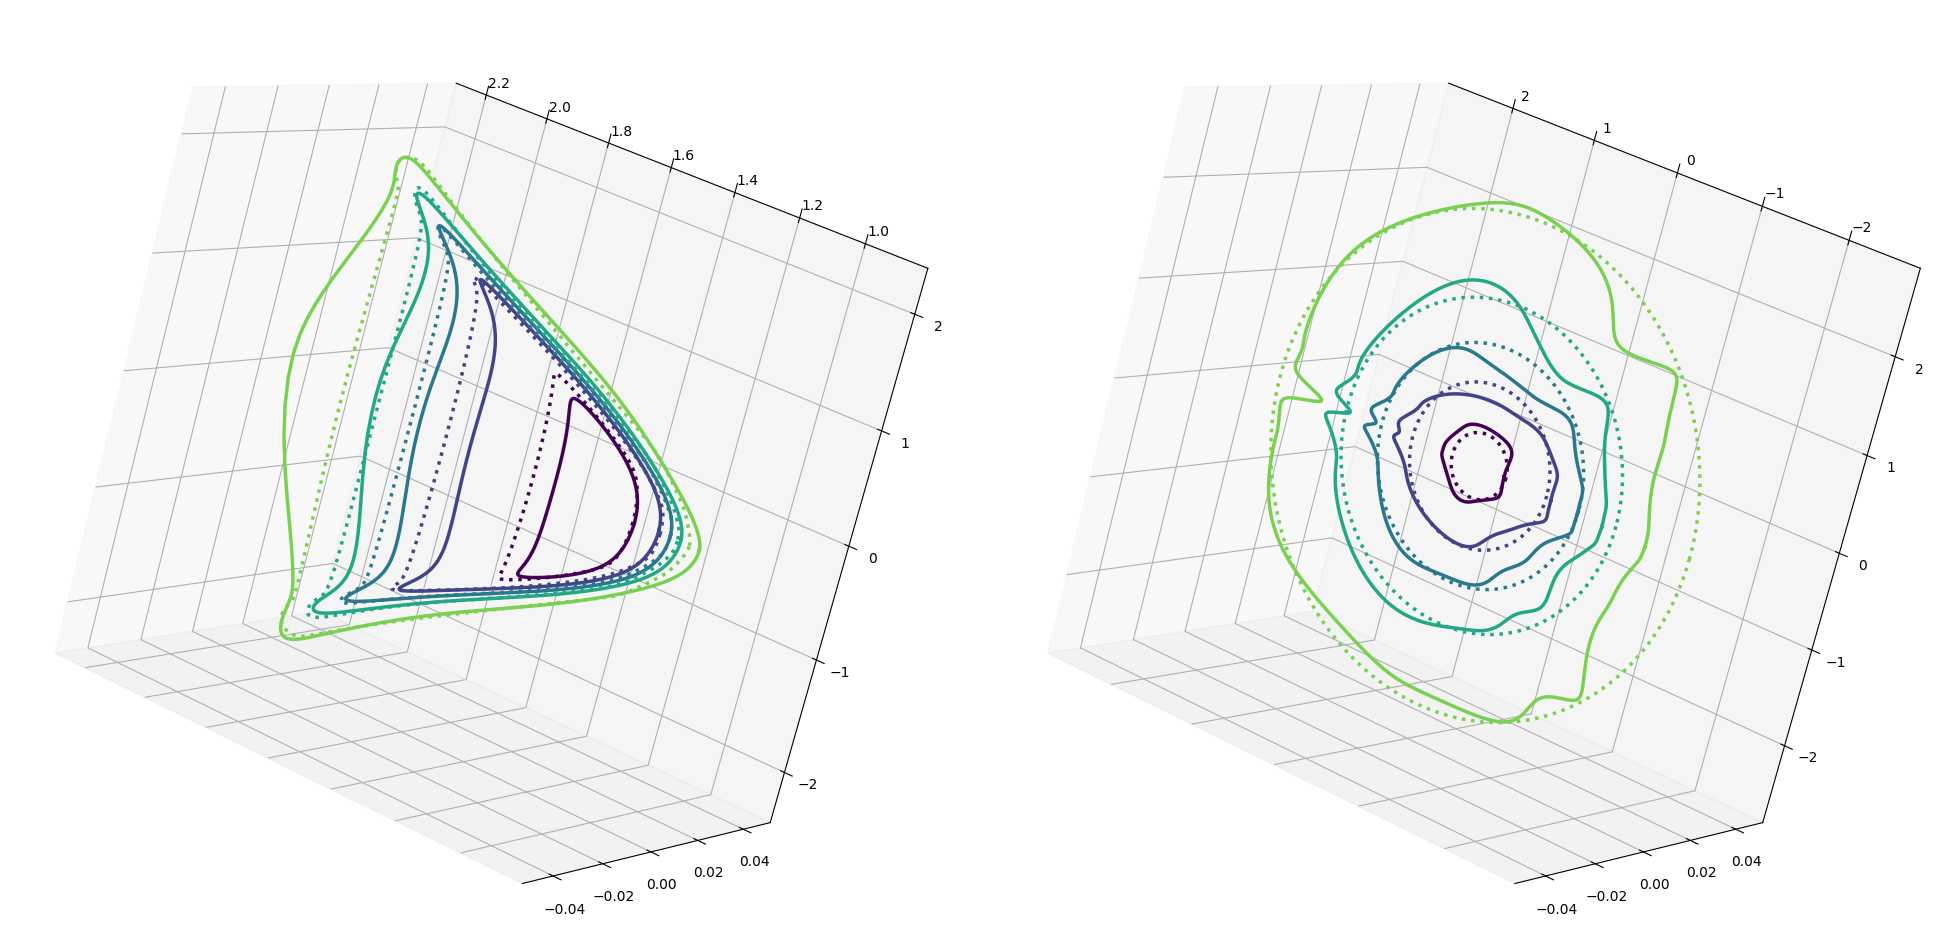

In [7]:
from utils.plot import plot_quantile_levels_from_dataset

plot_quantile_levels_from_dataset(
    model=quantile, dataset=synthetic_dataset, conditional_value=torch.Tensor([[1.5]]),
    number_of_quantile_levels=5, tensor_parameters={}
)

In [229]:
from functools import partial

def get_jacobian_vector_product(
    quantile: FlowMatchingQuantile,
    state: torch.Tensor,
    condition: torch.Tensor,
    interpolation_times: torch.Tensor,
    random_directions: torch.Tensor,
) -> torch.Tensor:

    def get_conditional_vector_field_as_a_function(_condition: torch.Tensor):
        return partial(quantile.vector_field_network, _condition)

    def calculate_jacobian_vector_product_per_tensor(
        _condition: torch.Tensor,
        _state: torch.Tensor,
        _random_direction: torch.Tensor
    ):
        assert (_condition.ndim <= 2 and _state.ndim <= 2 and _random_direction.ndim <= 2), \
            (
                f"{_condition.ndim=} ( should be less then 2 ) "
                f"{_state.ndim=} ( should be less then 2 ) "
                f"{_random_direction.ndim=} ( should be less then 2 )"
            )
    
        _condition = _condition if _condition.ndim != 1 else _condition.unsqueeze(0)
        _state = _state if _state.ndim != 1 else _state.unsqueeze(0)
        _random_direction = _random_direction if _random_direction.ndim != 1 else _random_direction.unsqueeze(0)

        conditional_vector_field_as_a_function = get_conditional_vector_field_as_a_function(_condition=_condition)
        _, jacobian_vector_product = torch.func.jvp(
            conditional_vector_field_as_a_function,
            (_state, ),
            (_random_direction, )
        )
        return jacobian_vector_product.squeeze(0)
    
    time_embedding = quantile.time_embedding_network(interpolation_times)
    full_condition = torch.cat([condition, time_embedding], dim=1)

    return torch.vmap(
        lambda _condition, _state, _random_directions:
            torch.vmap(
                lambda _random_direction: \
                    calculate_jacobian_vector_product_per_tensor(
                        _condition = _condition,
                        _state = _state, 
                        _random_direction = _random_direction
                    ),
                in_dims=-1, out_dims=-1
            )(_random_directions)
    )(full_condition, state, random_directions)


def get_vector_jacobian_product(
    quantile: FlowMatchingQuantile,
    state: torch.Tensor,
    condition: torch.Tensor,
    interpolation_times: torch.Tensor,
    random_directions: torch.Tensor,
) -> torch.Tensor:
    def get_conditional_vector_field_as_a_function(_condition: torch.Tensor):
        return partial(quantile.vector_field_network, _condition)

    def calculate_vector_jacobian_product_per_direction_batch(
        _condition: torch.Tensor,
        _state: torch.Tensor,
        _random_directions: torch.Tensor
    ):
        assert (_condition.ndim <= 2 and _state.ndim <= 2 and _random_directions.ndim == _state.ndim + 1), \
            (
                f"{_condition.ndim=} ( should be less then 2 ) "
                f"{_state.ndim=} ( should be less then 2 ) "
                f"{_random_directions.ndim=} ( should be one more then _state and _condition dim )"
            )
    
        _condition = _condition if _condition.ndim != 1 else _condition.unsqueeze(0)
        _state = _state if _state.ndim != 1 else _state.unsqueeze(0)

        conditional_vector_field_as_a_function = get_conditional_vector_field_as_a_function(_condition=_condition)
        _, vector_jacobian_product_function = torch.func.vjp(
            conditional_vector_field_as_a_function,
            _state
        )
        vector_jacobian_products = torch.vmap(
            lambda _random_direction: \
                vector_jacobian_product_function(
                    _random_direction.unsqueeze(0)
                )[0].squeeze(0),
            in_dims=-1, out_dims=-1
        )(_random_directions)
        return vector_jacobian_products
    
    time_embedding = quantile.time_embedding_network(interpolation_times)
    full_condition = torch.cat([condition, time_embedding], dim=1)

    return torch.vmap(
        lambda _condition, _state, _random_directions:
            calculate_vector_jacobian_product_per_direction_batch(
                _condition=_condition,
                _state=_state,
                _random_directions=_random_directions
            )
    )(full_condition, state, random_directions)

import torch

def explicit_jacobian_vector_product(
    quantile,
    state: torch.Tensor,
    condition: torch.Tensor,
    interpolation_times: torch.Tensor,
    random_directions: torch.Tensor,
) -> torch.Tensor:
    """
    Explicitly computes (J(x) @ v) by forming the full Jacobian w.r.t. state via autograd,
    then multiplying by each direction vector.

    This is intended ONLY as a correctness check (very slow / memory-heavy).

    Assumptions (matching your current vmaps):
      - state:              (B, D)
      - condition:          (B, C)
      - interpolation_times:(B, T) or whatever your time_embedding_network expects
      - random_directions:  (B, D, K)  <-- directions indexed on the last axis (K)

    Returns:
      - jvp_explicit:       (B, D_out, K) where D_out is output dimension of vector_field_network.
        If your vector field is square, D_out == D == D_in.
    """
    # Build full condition the same way as your code
    time_embedding = quantile.time_embedding_network(interpolation_times)
    full_condition = torch.cat([condition, time_embedding], dim=1)

    if state.ndim != 2:
        raise ValueError(f"Expected state.ndim==2 (B,D). Got {state.shape=}")
    if full_condition.ndim != 2:
        raise ValueError(f"Expected full_condition.ndim==2 (B,C'). Got {full_condition.shape=}")
    if random_directions.ndim != 3:
        raise ValueError(f"Expected random_directions.ndim==3 (B,D,K). Got {random_directions.shape=}")

    B, D = state.shape
    if random_directions.shape[0] != B or random_directions.shape[1] != D:
        raise ValueError(
            f"Expected random_directions shape (B,D,K) matching state (B,D). "
            f"Got {random_directions.shape=} vs {state.shape=}"
        )

    # Compute per-sample explicit J and multiply by V
    outs = []
    for b in range(B):
        x = state[b].detach().clone().requires_grad_(True)         # (D,)
        cond_b = full_condition[b].detach()                        # (C',)
        V = random_directions[b]                                   # (D, K)

        def f(x_1d: torch.Tensor) -> torch.Tensor:
            # make it (1,*) for your network, then squeeze back to (*,)
            y = quantile.vector_field_network(cond_b.unsqueeze(0), x_1d.unsqueeze(0))
            return y.squeeze(0)  # (D_out,)

        y = f(x)
        if y.ndim != 1:
            raise ValueError(f"Expected vector field output per sample to be 1D. Got {y.shape=}")

        D_out = y.shape[0]

        # Build full Jacobian J: (D_out, D)
        J_rows = []
        for i in range(D_out):
            (gi,) = torch.autograd.grad(
                y[i], x,
                retain_graph=True,
                create_graph=False,
                allow_unused=False,
            )  # (D,)
            J_rows.append(gi)
        J = torch.stack(J_rows, dim=0)  # (D_out, D)

        # Multiply by V: (D_out, D) @ (D, K) -> (D_out, K)
        outs.append(J.T @ V)

    return torch.stack(outs, dim=0)  # (B, D_out, K)

In [233]:
quantile.to(dtype=torch.float64)
random_directions = torch.randn(64, 2, 32, dtype=torch.float64)
state = torch.randn(64, 2, dtype=torch.float64)
condition = torch.randn(64, 1, dtype=torch.float64)
interpolation = torch.rand(64, 1, dtype=torch.float64)

vjp = get_vector_jacobian_product(
    quantile=quantile,
    state=state,
    condition=condition,
    interpolation_times=interpolation,
    random_directions=random_directions
)

jvp = get_jacobian_vector_product(
    quantile=quantile,
    state=state,
    condition=condition,
    interpolation_times=interpolation,
    random_directions=random_directions
)

jvp_exp  = explicit_jacobian_vector_product(
    quantile=quantile,
    state=state,
    condition=condition,
    interpolation_times=interpolation,
    random_directions=random_directions
)

# max error
torch.allclose(vjp, jvp_exp), (vjp - jvp_exp).abs().max()

(True, tensor(6.6613e-14, dtype=torch.float64, grad_fn=<MaxBackward1>))

In [ ]:
jvp.shape, vjp.shape

(torch.Size([64, 2, 32]), torch.Size([64, 2, 32]))

In [89]:
from functools import partial

parital_condition = torch.randn(64, 1)
state = torch.randn(64, 2, requires_grad=True)
time = torch.rand(64, 1)
time_embedding = quantile.time_embedding_network(time)
condition = torch.cat([parital_condition, time_embedding], dim=1)

ft_jacobian = torch.func.vmap(
    torch.func.jacrev(
        lambda condition, state: quantile.vector_field_network(condition.unsqueeze(0), state.unsqueeze(0)).squeeze(0),
        argnums=1
    )
)(torch.cat([parital_condition, time_embedding], dim=1), state)

random_direction = torch.randn(64, 5, 2)
newfunc = partial(quantile.vector_field_network, condition)

def f_single(cond, x):
    return quantile.vector_field_network(cond.unsqueeze(0), x.unsqueeze(0)).squeeze(0)

jvp_out = torch.func.vmap(
    lambda cond, x, v: torch.func.jvp(lambda x_: f_single(cond, x_), (x,), (v,))[1]
)(condition, state, random_direction)

vjp_out = torch.func.vmap(
    lambda cond, x, cot: torch.func.vjp(lambda x_: f_single(cond, x_), x)[1](cot)[0]
)(condition, state, random_direction) 

torch.allclose(
    jvp_out,
    torch.bmm(ft_jacobian, random_direction.unsqueeze(-1)).squeeze(-1),
    atol=1e-6,
    rtol=1e-5
), torch.allclose(
    vjp_out,
    torch.bmm(ft_jacobian.transpose(1, 2), random_direction.unsqueeze(-1)).squeeze(-1),
    atol=1e-6,
    rtol=1e-5
)

RuntimeError: Trying to set a forward gradient that has a different size than that of the original Tensor, this is not supported. Tensor is of size [2] while the given forward gradient is of size [5, 2].

In [80]:
random_direction = torch.randn(64, 2)
newfunc = partial(quantile.vector_field_network, condition)
jacobian_in_random_direction = torch.func.jvp(partial(quantile.vector_field_network, condition), (state, ), (random_direction, ))[0]
torch.allclose(jacobian_in_random_direction, torch.bmm(ft_jacobian, random_direction.unsqueeze(-1)).squeeze())

False

In [71]:
random_direction.shape

torch.Size([64, 2, 1])

In [93]:
torch.randn(*random_direction.shape, 2).shape

torch.Size([64, 5, 2, 2])